In [69]:
import os
CONDA_PREFIX = '/root/miniforge3'

def list_elements(path, *substrings):
  patterns = ".*".join(substrings)
  %env SEARCH $patterns
  %env SEARCH_DIR $path
  print("\nelements matching: [", ", ".join(substrings), "]\n")
  !find $SEARCH_DIR -name "*.spice" -exec grep -H "^\.subckt.*$SEARCH" {} \;

path = f"{CONDA_PREFIX}/share/pdk"

list_elements(path, "cap", "mim")

env: SEARCH=cap.*mim
env: SEARCH_DIR=/root/miniforge3/share/pdk

elements matching: [ cap, mim ]

/root/miniforge3/share/pdk/sky130A/libs.tech/combined/continuous/models_capacitors.spice:.subckt  sky130_fd_pr__cap_mim_m3_1 c0 c1  mult=1
/root/miniforge3/share/pdk/sky130A/libs.tech/combined/continuous/models_capacitors.spice:.subckt  sky130_fd_pr__cap_mim_m3_2 c0 c1  mult=1
/root/miniforge3/share/pdk/sky130A/libs.ref/sky130_fd_pr/spice/sky130_fd_pr__cap_mim_m3_1.model.spice:.subckt  sky130_fd_pr__cap_mim_m3_1 c0 c1 w=1 l=1 mf=1
/root/miniforge3/share/pdk/sky130A/libs.ref/sky130_fd_pr/spice/sky130_fd_pr__cap_mim_m3_2.model.spice:.subckt  sky130_fd_pr__cap_mim_m3_2 c0 c1 w=1 l=1 mf=1


# Test NMOS Characteristic Curve

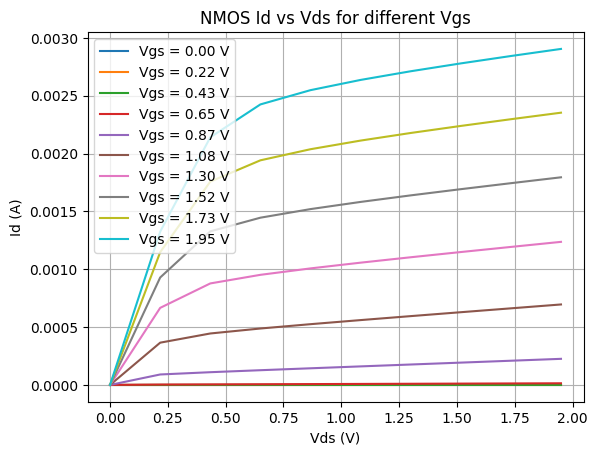

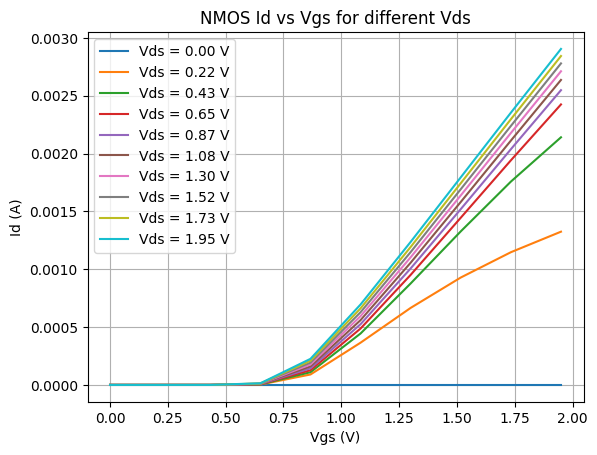

In [3]:
import matplotlib.pyplot as plt
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import numpy as np
# Create a minimal circuit simulation of the NMOS model
circuit = Circuit('NMOS Characteristic Curves')
circuit.lib(f'/root/miniforge3/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
# silence xyce warnings
logging.basicConfig(filename='pyspice_warnings.log', level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
pyspice_logger = logging.getLogger('PySpice')
pyspice_logger.setLevel(logging.WARNING)




# Define the NMOS transistor
circuit.X(1,  'sky130_fd_pr__nfet_01v8', 'drain', 'gate', circuit.gnd, circuit.gnd, l=0.15, w=0.5,)

# Define the voltage sources
circuit.V(1, 'gate', circuit.gnd, 0@u_V)
circuit.V(2, 'drain', 'rgnd', 0@u_V)
circuit.R('rgnd', 'rgnd', circuit.gnd, 10@u_Ohm)

# Sweep Vgs and Vds
vgs_values = np.linspace(0, 1.95, 10)  # Gate-Source voltage values
vds_values = np.linspace(0, 1.95, 10)  # Drain-Source voltage values

# Store the results
results = {}

for vgs in vgs_values:
    circuit['V1'].dc_value = vgs@u_V
    id_values = {}
    for vds in vds_values:
        circuit['V2'].dc_value = vds@u_V
        simulator = circuit.simulator(simulator="xyce-parallel")
        analysis = simulator.operating_point()
        id_values[vds] = float(-analysis["rgnd"])
    results[vgs] = id_values

# Plot the results
for vgs in vgs_values:
    id_values = [results[vgs][vds] for vds in vds_values]
    plt.plot(vds_values, id_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('Id (A)')
plt.title('NMOS Id vs Vds for different Vgs')
plt.legend()
plt.grid()
plt.show()


for vds in vds_values:
    id_values = [results[vgs][vds] for vgs in vgs_values]
    plt.plot(vgs_values, id_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('Id (A)')
plt.title('NMOS Id vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()


In [ ]:
simulator.reset_analysis = lambda *args: args
analysis = simulator.transient(step_time=0.01@u_ns, end_time=0.05@u_us)
with open("netlist.spice", "w") as f: f.write(str(analysis.simulation))
!Xyce -hspice-ext all netlist.spice

# Test CMOS Synapse

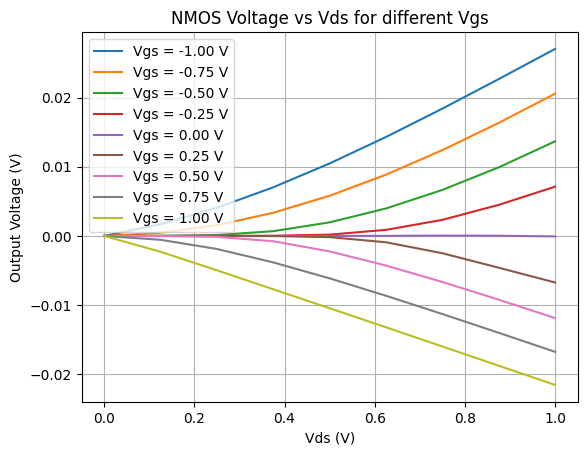

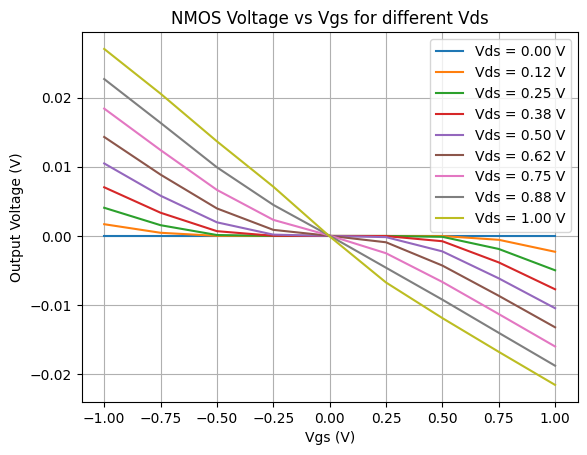

In [1]:
import matplotlib.pyplot as plt
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import numpy as np
# Create a minimal circuit simulation of the NMOS model
circuit = Circuit('NMOS Characteristic Curves')
circuit.lib(f'/root/miniforge3/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
# silence xyce warnings
logging.basicConfig(filename='pyspice_warnings.log', level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
pyspice_logger = logging.getLogger('PySpice')
pyspice_logger.setLevel(logging.WARNING)




# Define the NMOS transistor

circuit.X('pfet',  'sky130_fd_pr__pfet_01v8', 'drain', 'gate', 'vdd', 'vdd', l=0.15, w=0.42*3.2)
circuit.X('nfet',  'sky130_fd_pr__nfet_01v8', 'drain', 'gate', 'vss', 'vss', l=0.15, w=0.42,)

# Define the voltage sources
circuit.V('weight', 'gate', '0', 0@u_V)
circuit.V('inp', 'vdd', circuit.gnd, 0@u_V)
circuit.V('inn', circuit.gnd, 'vss', 0@u_V)

circuit.R('out', 'drain', 'out', 100@u_Ohm)
circuit.V('out', 'out', circuit.gnd, 0@u_V)

# Sweep Vgs and Vds
vgs_values = np.linspace(-1.0, 1.0, 9)  # Gate-Source voltage values
vds_values = np.linspace(0.0, 1.0, 9)  # Drain-Source voltage values
nudge_values = [-0.01, 0, 0.01]
# Store the results
results = {}
update_results = {}
voltage_results = {}

for vgs in vgs_values:
    circuit['Vweight'].dc_value = vgs@u_V
    id_values = {}
    update_values = {}
    voltage_values = {}
    for vds in vds_values:
        id_values[vds] = {}
        update_values[vds] = {}
        voltage_values[vds] = {}
        for nudge in nudge_values:
            circuit['Vinp'].dc_value = vds@u_V
            circuit['Vinn'].dc_value = vds@u_V
            circuit['Vout'].dc_value = nudge@u_V
            simulator = circuit.simulator(simulator="xyce-parallel")
            analysis = simulator.operating_point()
            id_values[vds][nudge] = float(-analysis["Vout"])
            update_values[vds][nudge] = float(analysis["drain"]) - float(analysis["out"])
            voltage_values[vds][nudge] = float(analysis["drain"])
    results[vgs] = id_values
    update_results[vgs] = update_values
    voltage_results[vgs] = voltage_values

# Plot the results
for vgs in vgs_values:
    voltage_values = [voltage_results[vgs][vds][0] for vds in vds_values]
    plt.plot(vds_values, voltage_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('Output Voltage (V)')
plt.title('NMOS Voltage vs Vds for different Vgs')
plt.legend()
plt.grid()
plt.show()


for vds in vds_values:
    voltage_values = [voltage_results[vgs][vds][0] for vgs in vgs_values]
    plt.plot(vgs_values, voltage_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('Output Voltage (V)')
plt.title('NMOS Voltage vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()

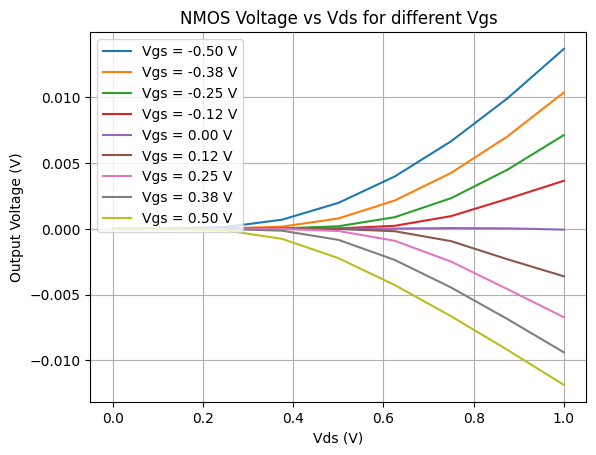

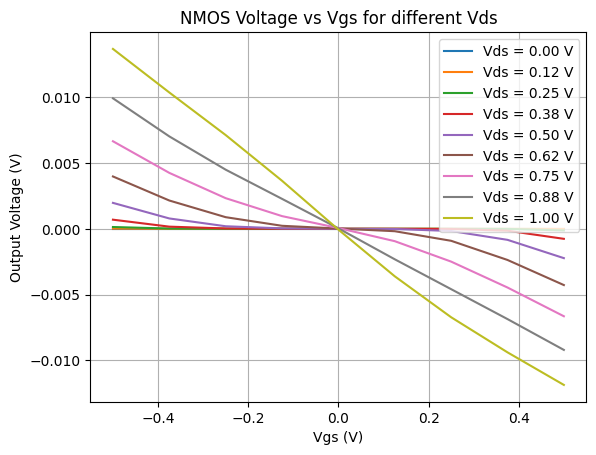

In [27]:

# Plot the results
for vgs in vgs_values:
    voltage_values = [voltage_results[vgs][vds][0] for vds in vds_values]
    plt.plot(vds_values, voltage_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('Output Voltage (V)')
plt.title('NMOS Voltage vs Vds for different Vgs')
plt.legend(loc='upper left')
plt.grid()
plt.show()


for vds in vds_values:
    voltage_values = [voltage_results[vgs][vds][0] for vgs in vgs_values]
    plt.plot(vgs_values, voltage_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('Output Voltage (V)')
plt.title('NMOS Voltage vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()

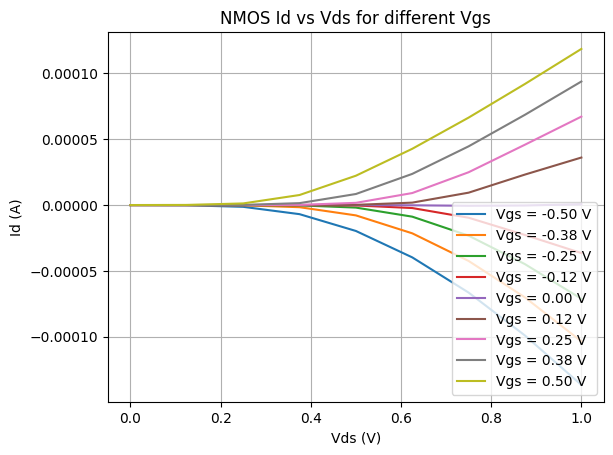

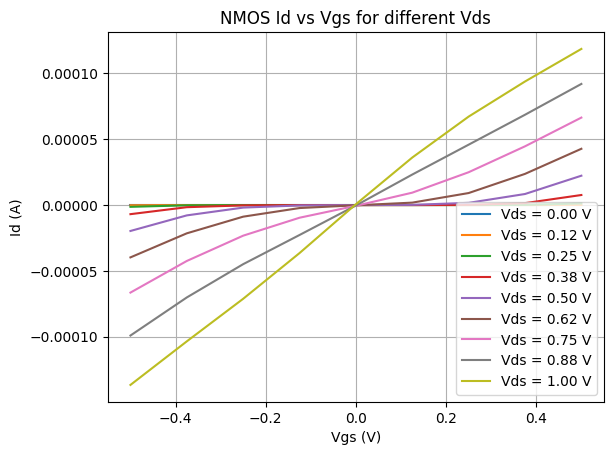

In [28]:


# Plot the results
for vgs in vgs_values:
    id_values = [results[vgs][vds][0] for vds in vds_values]
    plt.plot(vds_values, id_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('Id (A)')
plt.title('NMOS Id vs Vds for different Vgs')
plt.legend()
plt.grid()
plt.show()


for vds in vds_values:
    id_values = [results[vgs][vds][0] for vgs in vgs_values]
    plt.plot(vgs_values, id_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('Id (A)')
plt.title('NMOS Id vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()




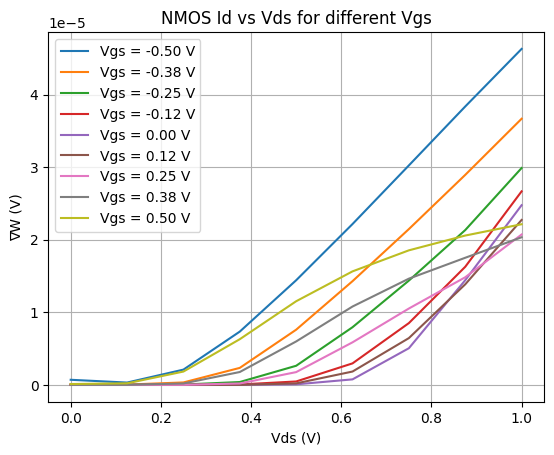

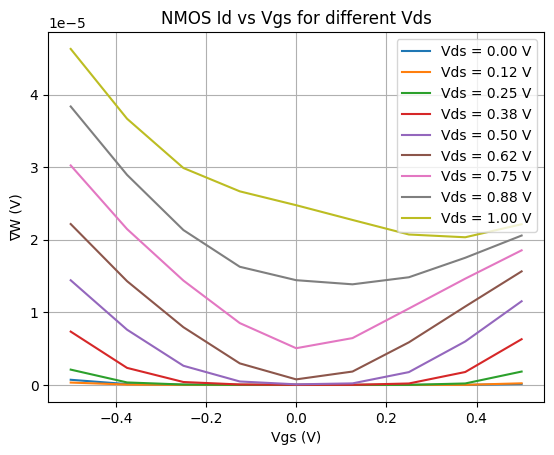

In [29]:
# Plot the updates
for vgs in vgs_values:
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][min(nudge_values)] for vds in vds_values]
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][0] for vds in vds_values]
    update_values = [update_results[vgs][vds][min(nudge_values)]-update_results[vgs][vds][0] for vds in vds_values]
    plt.plot(vds_values, update_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('∇W (V)')
plt.title('NMOS Id vs Vds for different Vgs')
plt.legend()
plt.grid()
plt.show()


for vds in vds_values:
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][min(nudge_values)] for vgs in vgs_values]
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][0] for vgs in vgs_values]
    update_values = [update_results[vgs][vds][min(nudge_values)]-update_results[vgs][vds][0] for vgs in vgs_values]
    plt.plot(vgs_values, update_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('∇W (V)')
plt.title('NMOS Id vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()

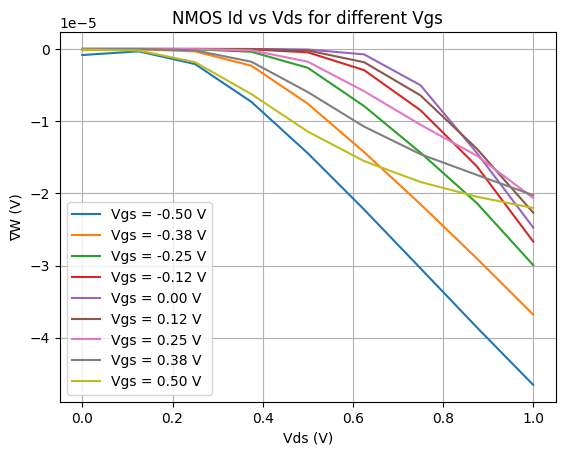

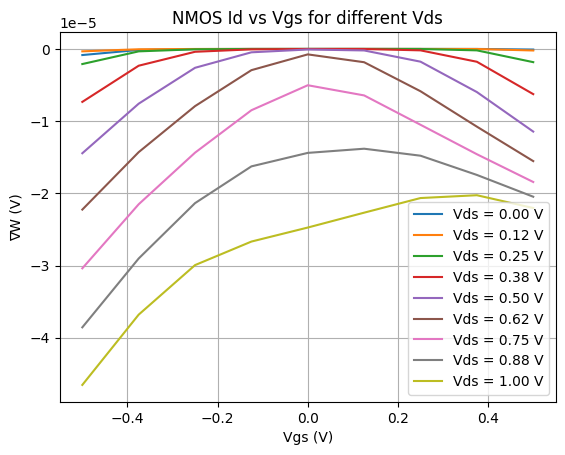

In [31]:
# Plot the updates
for vgs in vgs_values:
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][min(nudge_values)] for vds in vds_values]
    update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][0] for vds in vds_values]
    #update_values = [update_results[vgs][vds][min(nudge_values)]-update_results[vgs][vds][0] for vds in vds_values]
    plt.plot(vds_values, update_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('∇W (V)')
plt.title('NMOS Id vs Vds for different Vgs')
plt.legend()
plt.grid()
plt.show()


for vds in vds_values:
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][min(nudge_values)] for vgs in vgs_values]
    update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][0] for vgs in vgs_values]
    #update_values = [update_results[vgs][vds][min(nudge_values)]-update_results[vgs][vds][0] for vgs in vgs_values]
    plt.plot(vgs_values, update_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('∇W (V)')
plt.title('NMOS Id vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()

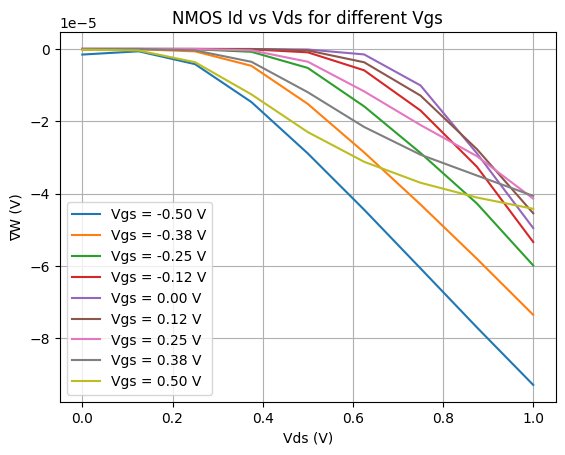

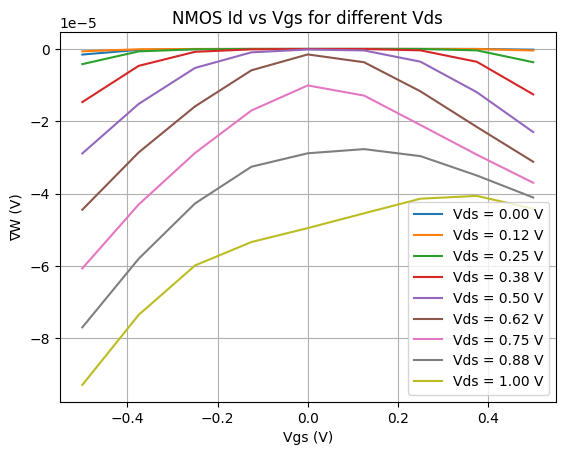

In [32]:
# Plot the updates
for vgs in vgs_values:
    update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][min(nudge_values)] for vds in vds_values]
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][0] for vds in vds_values]
    #update_values = [update_results[vgs][vds][min(nudge_values)]-update_results[vgs][vds][0] for vds in vds_values]
    plt.plot(vds_values, update_values, label=f'Vgs = {vgs:.2f} V')

plt.xlabel('Vds (V)')
plt.ylabel('∇W (V)')
plt.title('NMOS Id vs Vds for different Vgs')
plt.legend()
plt.grid()
plt.show()


for vds in vds_values:
    update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][min(nudge_values)] for vgs in vgs_values]
    #update_values = [update_results[vgs][vds][max(nudge_values)]-update_results[vgs][vds][0] for vgs in vgs_values]
    #update_values = [update_results[vgs][vds][min(nudge_values)]-update_results[vgs][vds][0] for vgs in vgs_values]
    plt.plot(vgs_values, update_values, label=f'Vds = {vds:.2f} V')

plt.xlabel('Vgs (V)')
plt.ylabel('∇W (V)')
plt.title('NMOS Id vs Vgs for different Vds')
plt.legend()
plt.grid()
plt.show()